In [1]:
import sys
import itertools
import time
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import scipy.stats as stats
sys.path.append("H:\chcd_py")
from chcd_py.helpers.db_utils import get_dsn
from chcd_py.helpers.helpers import explain_query, timer_profile, query_comparison_profiler

In [15]:
@timer_profile
def dx_equal_query(cursor, ind_var, arg):
    '''performs a simple count equal query'''
    cursor.execute(f'select count(*) from {ind_var} where diag_cd = %s', (arg, ))
    return cursor.fetchall()


@timer_profile
def dx_equal_by_source_query(cursor, ind_var, arg):
    '''performs a simple count of a single diagnosis query'''
    cursor.execute(f'select count(*) from {ind_var} where diag_cd = %s and data_source = %s', arg)
    return cursor.fetchall()


@timer_profile
def dx_in_by_source_query(cursor, ind_var, arg):
    cursor.execute(f'select count(*) from {ind_var} where diag_cd in (%s, %s, %s) and data_source = %s', arg)
    return cursor.fetchall()


@timer_profile
def dx_join_query(cursor, ind_var, arg):
    cursor.execute('drop table if exists dev.gm_dx_temp;')
    cursor.execute(f"""
create table dev.gm_dx_temp as 
select * from reference_tables.ref_cms_icd_cm_codes rcicc 
where cd_value like %s ESCAPE ''""", 
                   (arg[0][:3]+'%',))
    cursor.execute(f'''select count(*) from {ind_var} as dx
    inner join dev.gm_dx_temp tmp on dx.diag_cd = tmp.cd_value and data_source = %s;''', (arg[1], ))
    return cursor.fetchall()

In [3]:
con = psycopg2.connect(get_dsn())
con.autocommit = True

In [6]:
np.random.seed(1)

dx_codes = ['05410', 'J050', '2724', 'M79672', '4720', 'Z7982',
            'H4010X1', 'Z3492', 'R41841', '6101','F519', 'Z30432',
            'S83412A','C8296', 'K654', 'T8484XA', '4739', 'M5137',
            '49390', 'V0489']

data_source_list= ['optz', 'optd', 'truv','mdcd', 'mcrn', 'mcrt']

dx_code_data_source_combos = []

for dx_code in dx_codes:
    for data_source in data_source_list:
        dx_code_data_source_combos.append((dx_code, data_source))
        
        
sample_size = 20
        
np.random.shuffle(dx_code_data_source_combos)
dx_code_data_source_combos = dx_code_data_source_combos[:sample_size]

#for in query
dx_codes_combo = list(itertools.combinations(dx_codes,3))
np.random.shuffle(dx_codes_combo)
dx_codes_combo = dx_codes_combo[:sample_size]
dx_codes_combo = [i + (np.random.choice(data_source_list, 1)[0],) for i in dx_codes_combo]

#for join query 

dx_join_codes = [(np.random.choice(dx_codes, 1)[0], np.random.choice(data_source_list, 1)[0]) for i in range(sample_size)]



table_list = ['dev.gm_temp_claim_diag_no_ix', 'data_warehouse.claim_diag', 'dev.gm_temp_claim_diag']

x_labels = ['No Index', 'Index Only', 'Index and Partition']


## select count(*) from {claim_diag} where diag_cd = %s

************************************************************

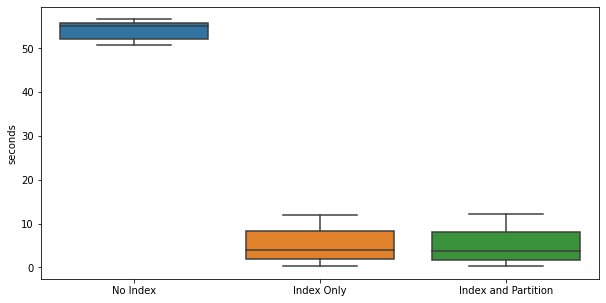

In [16]:
dx_results = query_comparison_profiler(con, table_list, dx_equal_query, dx_codes, x_labels)

In [17]:
dx_results = dx_results.describe()
dx_results[x_labels].round(decimals=2)

,No Index,Index Only,Index and Partition
count,20.00,20.00,20.00
mean,54.41,4.78,4.73
std,1.98,3.76,3.83
min,50.69,0.22,0.20
25%,52.15,1.85,1.74
50%,55.21,3.84,3.79
75%,55.85,8.26,8.00
max,56.64,11.90,12.09


## select count(*) from {claim_diag} where diag_cd = %s and data_source = %s

************************************************************

,No Index,Index Only,Index and Partition,args,query_results
0,60.213688,3.222522,0.778771,"(T8484XA, mcrt)",358850
1,64.393914,6.736985,1.257085,"(6101, optz)",1369152
2,64.702264,6.694199,0.407156,"(6101, mcrt)",151941
3,64.446813,8.707371,0.435490,"(V0489, mdcd)",370251
4,60.643218,1.224609,0.162966,"(S83412A, mcrt)",34929
5,63.623265,2.519214,0.073204,"(Z3492, mcrn)",3689
6,64.847104,11.696750,2.077723,"(Z7982, optd)",15890071
7,63.898885,0.245386,0.038898,"(C8296, mdcd)",62
8,62.140045,5.508478,1.015604,"(R41841, optz)",2633269
9,65.118765,10.556829,5.863831,"(4739, truv)",15701565


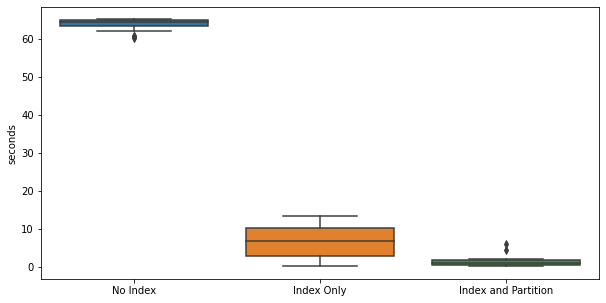

In [7]:

dx_equal_results = query_comparison_profiler(con, table_list, dx_equal_by_source_query, 
                                             dx_code_data_source_combos, x_labels)
dx_equal_results

In [11]:
dx_equal_description = dx_equal_results.describe()
dx_equal_description[x_labels].round(decimals=2)

,No Index,Index Only,Index and Partition
count,20.00,20.00,20.00
mean,63.66,6.36,1.36
std,1.73,4.11,1.44
min,60.21,0.25,0.04
25%,63.25,2.84,0.43
50%,64.42,6.72,1.05
75%,64.86,10.18,1.61
max,65.12,13.26,5.86


In [18]:

tvalue, pvalue = stats.ttest_rel(dx_equal_description['Index Only'], 
                                dx_equal_description['Index and Partition'])
print(tvalue, pvalue)

3.5461230671044124 0.009392421682897655


## In Query

select count(*) from {ind_var} where diag_cd in (%s, %s, %s) and data_source = %s

************************************************************

,No Index,Index Only,Index and Partition,args,query_results
0,59.397579,11.296124,1.900548,"(4720, T8484XA, V0489, optd)",7756325
1,58.034465,7.870523,0.555606,"(05410, H4010X1, R41841, mdcd)",1082763
2,58.214013,12.659736,2.062078,"(J050, M79672, Z30432, optz)",6005827
3,57.598572,5.275629,2.963645,"(05410, Z30432, S83412A, truv)",2434294
4,60.741359,18.614801,9.936486,"(2724, 4720, Z7982, optz)",85234288
5,59.172429,11.134646,0.798562,"(H4010X1, 6101, 4739, mcrn)",760764
6,59.329838,15.259921,1.364013,"(M79672, 6101, 4739, mcrn)",3610273
7,58.097313,5.913491,0.508776,"(H4010X1, R41841, F519, mdcd)",1021405
8,61.624441,15.783960,2.815097,"(J050, 4720, Z7982, mcrt)",48410077
9,59.123903,16.481355,2.569850,"(J050, M79672, 49390, mcrt)",7909783


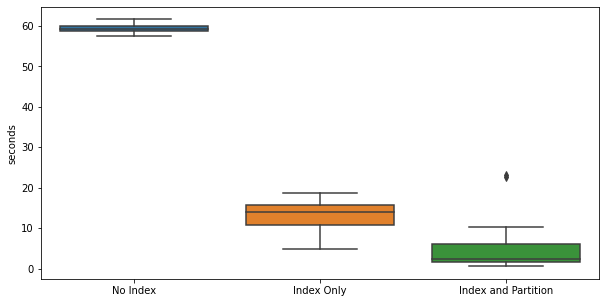

In [20]:
dx_in_results = query_comparison_profiler(con, table_list, dx_in_by_source_query, 
                                             dx_codes_combo, x_labels)
dx_in_results

In [22]:
dx_in_description = dx_in_results.describe()
dx_in_description[x_labels].round(decimals=2)

,No Index,Index Only,Index and Partition
count,20.00,20.00,20.00
mean,59.41,12.74,5.24
std,1.24,4.25,6.66
min,57.60,4.84,0.51
25%,58.72,10.75,1.52
50%,59.25,13.92,2.38
75%,59.89,15.80,6.01
max,61.62,18.61,23.00


## Join Query

************************************************************

,No Index,Index Only,Index and Partition,args,query_results
0,70.902839,72.313646,21.136538,"(T8484XA, optd)",2525968
1,64.626499,4.252560,0.654056,"(J050, mdcd)",465240
2,84.076979,46.391339,25.871028,"(Z30432, truv)",18894091
3,73.194100,64.016968,9.298664,"(2724, optz)",114090432
4,82.565064,37.566774,21.394002,"(V0489, truv)",110891717
5,68.667128,68.849125,14.432956,"(V0489, mcrn)",4674463
6,65.414708,46.609618,4.653280,"(Z3492, mdcd)",9864928
7,69.665686,69.726090,14.652358,"(T8484XA, mcrn)",2230008
8,72.050258,72.264735,22.820848,"(S83412A, mcrt)",2509642
9,71.821811,63.612983,8.182969,"(2724, mcrt)",71887528


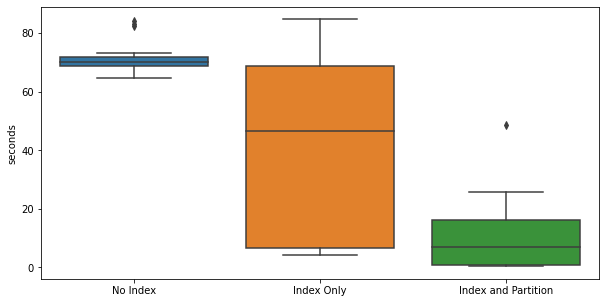

In [23]:
dx_join_results = query_comparison_profiler(con, table_list, dx_join_query, 
                                             dx_join_codes, x_labels)
dx_join_results

In [24]:
dx_join_description = dx_join_results.describe()
dx_join_description[x_labels].round(decimals=2)

,No Index,Index Only,Index and Partition
count,20.00,20.00,20.00
mean,71.42,42.14,10.92
std,5.68,28.98,12.42
min,64.63,4.25,0.32
25%,68.69,6.46,0.65
50%,70.28,46.50,6.82
75%,72.04,68.90,16.27
max,84.08,84.76,48.75
